# 5. Advanced Earth Engine

This module is focused on helping you build skills to scale your analysis in Earth Engine. We will cover topics ranging from building an app, code sharing and using the Python API for bulk exports and advanced analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb on
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Automatic pdb calling has been turned ON


In [2]:
import ee
import geemap
ee.Initialize()

## Client vs. Server

The User Interface elements in your Code Editor - Map View, Drawing Tools etc. are "client-side" elements. They run in **YOUR** browser. `Image Collections`, `feature collections`, calculations on Earth Engine objects etc. are "server-side" elements. They run in Google’s data center. You cannot mix both these objects.

- To convert client-side objects to server-side objects, you can use the appropriate API function. Server-side functions start with `ee.`, such `ee.Date()`, `ee.Image()` etc.
- To convert server-side objects to client-side objects, you can call `.getInfo()` on the Earth Engine object. For the Python API, this is the only way to extract information from a server-side object, but the Javascript API provides a better (and preferred) - method for bring server-side objects to client-side using the `evaluate()` method. This method asynchronously retrieves the value of the object, without blocking the user interface - meaning it will let your code continue to execute while it fetches the value.

In [3]:
date = '2020-01-01' # This is client-side
print(type(date))

eedate = ee.Date('2020-01-01').format()
print(type(eedate)) 

<class 'str'>
<class 'ee.ee_string.String'>


In [4]:
# To bring server-side objects to client-side, you can call .getInfo()

clientdate = eedate.getInfo()
print(clientdate)
print(type(clientdate)) 

2020-01-01T00:00:00
<class 'str'>


In [5]:
# getInfo() blocks the execution of your code till the value is fetched
# If the value takes time to compute, your code editor will freeze
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
filtered = s2.filter(ee.Filter.date('2020-01-01', '2020-01-31'))

numImages = filtered.size().getInfo()
print(numImages)

266725


## Building and Publishing an App 

Earth Engine comes with a User Interface API that allows you to build an interactive web application powered by Earth Engine. Building a web mapping application typically requires the skills of a full stack developer and are out of reach for most analysts and scientists. But the Earth Engine User Interface API makes this process much more accessible by providing ready-to-use widgets, such as Buttons, Drop-down Menus, Sliders etc. - and free cloud hosting to allow anyone to publish an app with just a few lines of code.

The apps run in your browser, so they need to use client-side functions. All the user interface functions are contained in the ui. package - such as `ui.Select()`, `ui.Button()`. You can create those elements by calling these functions with appropriate parameters. The main container object is the `ui.Panel()` which can contain different types of widgets. Learn more in the Earth Engine User Interface API section of the Earth Engine User Guide.

The code below shows how to build an app called Night Lights Explorer that allows anyone to pick a year/month and load the VIIRS Nighttime Day/Night Band Composite for the selected month. Copy/paste the code below to your Code Editor and click Run.

In [6]:
import ipywidgets as widgets

In [7]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [8]:
style = {'description_width': 'initial'}
title = widgets.Text(
    description='Title:',
    value='Landsat Timelapse',
    width=200,
    style=style
)

In [9]:
bands = widgets.Dropdown(
    description='Select RGB Combo:',
    options=['Red/Green/Blue', 'NIR/Red/Green',  'SWIR2/SWIR1/NIR', 'NIR/SWIR1/Red','SWIR2/NIR/Red', 
             'SWIR2/SWIR1/Red', 'SWIR1/NIR/Blue', 'NIR/SWIR1/Blue', 'SWIR2/NIR/Green', 'SWIR1/NIR/Red'],
    value='NIR/Red/Green',
    style=style
)

In [10]:
hbox1 = widgets.HBox([title, bands])
hbox1

In [11]:
start_year = widgets.IntSlider(description='Start Year:', value=1984, min=1984, max=2019, style=style)

end_year = widgets.IntSlider(description='End Year:', value=2019, min=1984, max=2019, style=style)

hbox2 = widgets.HBox([start_year, end_year])
hbox2

In [12]:
speed = widgets.IntSlider(
    description='Frames per second:',
    tooltip='Frames per second:',
    value=10,
    min=1, 
    max = 30,
    style=style
)

download = widgets.Checkbox(
    value=False,
    description='Download the GIF',
    style=style
)

hbox3 = widgets.HBox([speed, download])
hbox3

In [13]:
font_size = widgets.IntSlider(description='Font size:', value=30, min=10, max=50, style=style)

font_color = widgets.ColorPicker(
    concise=False,
    description='Font color:',
    value='white',
    style=style
)

progress_bar_color = widgets.ColorPicker(
    concise=False,
    description='Progress bar color:',
    value='blue',
    style=style
)

hbox4 = widgets.HBox([font_size, font_color, progress_bar_color])
hbox4

In [14]:
submit = widgets.Button(
    description='Submit',
    button_style='primary',
    tooltip='Click the submit the request to create timelapse',
    style=style
)

output = widgets.Output()

In [15]:
def submit_clicked(b):
    
    with output:
        output.clear_output()
        if start_year.value >= end_year.value:
            print('The end year must be great than the start year.')
            return
        print('Computing...')
        
        Map.add_landsat_ts_gif(roi=Map.user_roi, label=title.value, start_year=start_year.value, 
                               end_year=end_year.value, start_date='05-01', end_date='10-31', 
                               bands=bands.value.split('/'), font_color=font_color.value, 
                               frames_per_second=speed.value, font_size=font_size.value, 
                               progress_bar_color=progress_bar_color.value, download=download.value)    
submit.on_click(submit_clicked)

In [16]:
submit

Button(button_style='primary', description='Submit', style=ButtonStyle(), tooltip='Click the submit the reques…

In [17]:
output

Output()

## Exporting an `ImageCollection`

One of the most commonly asked questions by Earth Engine users is - How do I download all images in a collection? The Earth Engine API allows you to export a single image, but not collection of images. The recommended way to do batch exports like this is to use the Python API’s `ee.batch.Export` functions and use a Python for-loop to iterate and export each image. The `ee.batch` module also gives you ability to control Tasks - allowing you to automate exports.

### Create a Collection

In [18]:
geometry = ee.Geometry.Point([107.61303468448624, 12.130969369851766])
s2 = ee.ImageCollection("COPERNICUS/S2")
rgbVis = {
  'min': 0.0,
  'max': 3000,
  'bands': ['B4', 'B3', 'B2'],
}

# Write a function for Cloud masking
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask) \
      .select("B.*") \
      .copyProperties(image, ["system:time_start"])

filtered = s2 \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01')) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
  .filter(ee.Filter.intersects('.geo', geometry)) \
  .map(maskS2clouds)

# Write a function that computes NDVI for an image and adds it as a band
def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('ndvi')
    return image.addBands(ndvi)

withNdvi = filtered.map(addNDVI)

### Export All Images

Exports are done via the `ee.batch` module. A key difference between javascript and Python version is that the region parameter needs to be supplied with actual geometry coordinates.

In [18]:
image_ids = withNdvi.aggregate_array('system:index').getInfo()
print('Total images: ', len(image_ids))

Total images:  31


In [19]:
palette = [
  'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
  '74A901', '66A000', '529400', '3E8601', '207401', '056201',
  '004C00', '023B01', '012E01', '011D01', '011301'];

ndviVis = {'min':0, 'max':0.5, 'palette': palette }

# Export with 100m resolution for this demo
for i, image_id in enumerate(image_ids):
    image = ee.Image(withNdvi.filter(ee.Filter.eq('system:index', image_id)).first())
    task = ee.batch.Export.image.toDrive(**{
        'image': image.select('ndvi').visualize(**ndviVis),
        'description': 'Image Export {}'.format(i+1),
        'fileNamePrefix': image.id().getInfo(),
        'folder':'earthengine',
        'scale': 100,
        'region': image.geometry().getInfo()['coordinates'],
        'maxPixels': 1e10
    })
    task.start()
    print('Started Task: ', i+1)

Started Task:  1
Started Task:  2
Started Task:  3
Started Task:  4
Started Task:  5
Started Task:  6
Started Task:  7
Started Task:  8
Started Task:  9
Started Task:  10
Started Task:  11
Started Task:  12
Started Task:  13
Started Task:  14
Started Task:  15
Started Task:  16
Started Task:  17
Started Task:  18
Started Task:  19
Started Task:  20
Started Task:  21
Started Task:  22
Started Task:  23
Started Task:  24
Started Task:  25
Started Task:  26
Started Task:  27
Started Task:  28
Started Task:  29
Started Task:  30
Started Task:  31


Or use `geemap`:

In [22]:
imgs = withNdvi.map(lambda img: ee.Image(img.select('ndvi')))
geemap.ee_export_image_collection(imgs, "data/", 100)

Total number of images: 31

Exporting 1/31: 20190113T031059_20190113T031703_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20190113T031059_20190113T031703_T48PYU.tif


Exporting 2/31: 20190128T031001_20190128T031602_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20190128T031001_20190128T031602_T48PYU.tif


Exporting 3/31: 20190207T030911_20190207T031859_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20190207T030911_20190207T031859_T48PYU.tif


Exporting 4/31: 20190212T030839_20190212T032044_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20190212T030839_20190212T032044_T48PYU.tif


Exporting 5/31: 20190217T030801_20190217T032232_T48PYU.tif
Generating URL ...
Please wait ...
Data downl

Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20191005T030601_20191005T030740_T48PYU.tif


Exporting 22/31: 20191015T030701_20191015T030849_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20191015T030701_20191015T030849_T48PYU.tif


Exporting 23/31: 20191025T030811_20191025T032242_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20191025T030811_20191025T032242_T48PYU.tif


Exporting 24/31: 20191119T031019_20191119T031219_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20191119T031019_20191119T031219_T48PYU.tif


Exporting 25/31: 20191124T031041_20191124T032030_T48PYU.tif
Generating URL ...
Please wait ...
Data downloaded to /Users/akramzaytar/projects/Learn/GEE/ezmap/notebooks/data/20191124T031041_20191124T032030_T48PYU.tif


Expor

### Manage Running/Waiting Tasks

You can manage/cancel tasks as well. Get a list of tasks and get state information on them:

In [26]:
tasks = ee.batch.Task.list()
for task in tasks:
    task_id = task.status()['id']
    task_state = task.status()['state']
    print(task_id, task_state)
    
    if task_state == 'RUNNING' or task_state == 'READY':
        task.cancel()
        print('Task {} canceled'.format(task_id))

MZEPQD67TXE5BBIFMQOGU4CH CANCELLED
ZG5TTM46HWMUTMN5DAXDHX2M CANCELLED
BNIPVTDXF4A4AYU5Y7XR5O3Q CANCELLED
KHIINMWX54MZALOSEG6OBZ6Z CANCEL_REQUESTED
ORNBNBKKKOCDSXOMO4IO7L3J CANCEL_REQUESTED
CYCXDGDMTX6DJU4Y6D6LY34J COMPLETED
ITECRIURTOLV2DUK5PUCGWYF COMPLETED
YNBG32HQN6FQIF2AHDZ3C6FF COMPLETED
IO6NOCWC6GU562V4EQ5SUQ37 COMPLETED
E6DTDIIQTQBVDCUNAD2BGSLA COMPLETED
VZWLPA3AXAOHR4DM6ELVNBB6 COMPLETED
2HIPSQJA5LA2Z6DD5ODFTNDN COMPLETED
TYNXDQAZOO3G6257WWEYXTNJ COMPLETED
URN7HCE3GRA5TJPTMNMZQPYJ COMPLETED
TJ6O3WXXVUOEZQESSXAN7O76 COMPLETED
ALMUIQKBFQNUED3JYCHAGON3 COMPLETED
QJGEFTEDQ3W2BGVVRV36PZTV COMPLETED
OB3FVDDYSVHHCIQUZUQ4XQG4 COMPLETED
G53F6GZRT4RCSZOV7L3KWNRX COMPLETED
CGLPPRYIAVWXYOOSFYYOVV7U COMPLETED
QFHIZBTNLM467FDHFVLN4ERS COMPLETED
Q24Y4CC66R2FVFW7JSWM3VAZ COMPLETED
4V2FIPUOSE5GHIBL6JG4YUEY COMPLETED
QCBO5X4IGAZYPSCKEV7AYI4U COMPLETED
SK6AFC6WOUOTYKUM75Q2GMOT COMPLETED
SA6EAL4DF3O72WADNBR4OGYF COMPLETED
QOSYHTRRIYKGGZ6OI6BBZMCR COMPLETED
O6LN7YF6OS2AMFVKY4ZTPKBM COMPLETED
L34JO2

## Advanced Supervised Classification Techniques

### Post-Processing Classification Results

Supervised classification results often contain salt-and-pepper noise caused by mis-classified pixels. It is usually preferable to apply some post-processing techniques to remove such noise. The following script contains the code for two popular techniques for post-processing classification results.

- Using un-supervised clustering to replacing classified value by majority value in each cluster.
- Replacing isolated pixels with surrounding value with a majority filter.

> Remember that the neighborhood methods are scale-dependent so the results will change as you zoom in/out. Export the results at the desired scale to see the effect of post-processing.

In [82]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [4]:
# Sentinel-2 Median Composite
composite = ee.Image("users/ujavalgandhi/e2e/arkavathy_2019_composite")
Map.addLayer(composite, {"min": 0, "max": 0.3, "bands": ['B4', 'B3', 'B2']}, 'RGB Composite')

In [5]:
# Raw Supervised Classification Results
classified = ee.Image("users/ujavalgandhi/e2e/arkavathy_final_classification")
Map.addLayer(classified, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']}, 'Original')
Map.centerObject(classified, 10)

#### Post-processing by Clustering

In [6]:
# Cluster using Unsupervised Clustering methods
seeds = ee.Algorithms.Image.Segmentation.seedGrid(5)

snic = ee.Algorithms.Image.Segmentation.SNIC(**{
  "image": composite.select('B.*'), 
  "compactness": 0,
  "connectivity": 4,
  "neighborhoodSize": 10,
  "size": 2,
  "seeds": seeds
})
clusters = snic.select('clusters')

# Assign class to each cluster based on 'majority' voting (using ee.Reducer.mode()
smoothed = classified.addBands(clusters)

clusterMajority = smoothed.reduceConnectedComponents(**{
  "reducer": ee.Reducer.mode(),
  "labelBand": 'clusters'
})

Map.addLayer(clusterMajority, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']},
  'Processed using Clusters');

#### Post-processing by replacing isolated pixels with surrounding values

In [7]:
# count patch sizes
patchsize = classified.connectedPixelCount(40, False)

# run a majority filter
filtered = classified.focal_mode(**{
    "radius": 10,
    "kernelType": 'square',
    "units": 'meters',
})
  
# updated image with majority filter where patch size is small
connectedClassified =  classified.where(patchsize.lt(25), filtered)
Map.addLayer(connectedClassified, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']},
  'Processed using Connected Pixels')

### PCA

PCA is a very useful technique in improving your supervised classification results. This is a statistical technique that compresses data from a large number of bands into fewer uncorrelated bands. 

You can run PCA on your image and add the first few (typically 3) principal component bands to the original composite before sampling training points. In the example below, you will notice that 97% of the variance from the 13-band original image is captured in the 3-band PCA image. 

**This sends a stronger signal to the classifier and improves accuracy by allowing it to distinguish different classes better**.

In [8]:
composite = ee.Image("users/ujavalgandhi/e2e/arkavathy_2019_composite")
boundary = ee.FeatureCollection("users/ujavalgandhi/e2e/arkavathy_boundary")
Map.addLayer(composite, {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.2}, "RGB")

*Note: Code adapted from https://developers.google.com/earth-engine/guides/arrays_eigen_analysis*.

In [15]:
def PCA(masked_img):
    """Calculates the principal components the input image."""
    img = masked_img.unmask()
    scale = 20
    region = boundary
    band_names = img.bandNames()
    
    # Mean center the data enable a faster covariance reducer
    # and an SD stretch of the principal components.
    mean_dict = img.reduceRegion(**{
        "reducer": ee.Reducer.mean(),
        "geometry": region,
        "scale": scale,
        "maxPixels": 1e9,
        "bestEffort": True,
        "tileScale": 16
    })
    means = ee.Image.constant(mean_dict.values(band_names))
    centered = img.subtract(means)
    
    def get_new_band_names(prefix):
        """Returns a list of new band names."""
        seq = ee.List.sequence(1, band_names.length())
        return seq.map(lambda b: ee.String(prefix).cat(ee.Number(b).int()))
    
    def get_principal_components(centered, scale, region):
        """Accepts mean centered image, a scale and a region in which ...
            to perform the analysis. It returns the principal components...
            in the region as a new image.
        """
        # Collapse the bands of the image into a 1D array per pixel.
        arrays = centered.toArray()
        
        # Compute the covariance of the bands within the region
        covar = arrays.reduceRegion(**{
            "reducer": ee.Reducer.centeredCovariance(),
            "geometry": region,
            "scale": scale,
            "maxPixels": 1e9,
            "bestEffort": True,
            "tileScale": 16
        })
        
        # Get the `array` covariance result and cast to an array
        # This represents the band-to-band covariance within the region
        covar_arr = ee.Array(covar.get("array"))
        
        # Perform an eigen analysis and slice apart the values and vectors
        eigens = covar_arr.eigen()
        
        # This is a P-length vector of Eigenvalues
        eigen_vals = eigens.slice(1, 0, 1)
        
        # Compute percentage variance of each component
        eigen_vals_list = eigen_vals.toList().flatten()
        total = eigen_vals_list.reduce(ee.Reducer.sum())
        percentage_var = eigen_vals_list.map(lambda item: ee.Number(item).divide(total).multiply(100).format("%.2f"))
        
        # This will allow us to decide how many components to capture ...
        # most of the vaiance in the input
        print(f"percentage variance of each component: {percentage_var}")
    
        # This is a PxP matrix with eigenvectors in rows
        eigen_vectors = eigens.slice(1, 1)
        
        # Convert the array image to 2D arrays for matrix computations
        arr_img = arrays.toArray(1)
        
        # Left multiply the image array by the matrix of eigenvectors
        principal_components = ee.Image(eigen_vectors).matrixMultiply(arr_img)
        
        # Turn the square roots of the Eigenvalues into a P-band image
        sd_img = ee.Image(eigen_vals.sqrt()).arrayProject([0]).arrayFlatten([get_new_band_names("sd")])
        
        # Turn the PCs into a P-band image, normalized by SD
        return principal_components\
            .arrayProject([0])\
            .arrayFlatten([get_new_band_names("pc")])\
            .divide(sd_img)
    
    pc_img = get_principal_components(centered, scale, region)
    return pc_img.mask(masked_img.mask())

In [17]:
# As you see from the printed results, ~97% of the variance
# from the original image is captured in the first 3 principal components
# We select those and discard others
pca = PCA(composite).select(["pc1", "pc2", "pc3"])

# Add the 3 PCA bands to the original image
# Use this image for sampling training points for
# supervised classification
composite = composite.addBands(pca)  

# PCA computation is expensive and can time out when displaying on the map
# Export the results and import them back
ee.batch.Export.image.toAsset(**{
  "image": pca,
  "description": 'Principal_Components_Image',
  "assetId": 'users/ujavalgandhi/e2e/arkavathy_pca',
  "region": boundary,
  "scale": 20,
  "maxPixels": 1e10})

# Once the export finishes, import the asset and display
pcaImported = ee.Image('users/ujavalgandhi/e2e/arkavathy_pca')
pcaVisParams = { "bands": ['pc1', 'pc2', 'pc3'], "min": -2, "max": 2}

Map.addLayer(pcaImported, pcaVisParams, 'Principal Components')

percentage variance of each component: ee.List({
  "functionInvocationValue": {
    "functionName": "List.map",
    "arguments": {
      "baseAlgorithm": {
        "functionDefinitionValue": {
          "argumentNames": [
            "_MAPPING_VAR_2_0"
          ],
          "body": {
            "functionInvocationValue": {
              "functionName": "Number.format",
              "arguments": {
                "number": {
                  "functionInvocationValue": {
                    "functionName": "Number.multiply",
                    "arguments": {
                      "left": {
                        "functionInvocationValue": {
                          "functionName": "Number.divide",
                          "arguments": {
                            "left": {
                              "argumentReference": "_MAPPING_VAR_2_0"
                            },
                            "right": {
                              "functionInvocationValue": {
          

### Multi-temporal Composites for Crop Classification

Crop classification is a difficult problem. A useful technique that aids in clear distinction of crops is to account for crop phenology. This technique can be applied to detect a specific type of crop or distinguish crops from other forms of vegetation. 

You can create composite images for different periods of the cropping cycle and create a stacked image to be used for classification. This allows the classifier to learn the temporal pattern and detect pixels that exhibit similar patterns.

In [18]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR")
basin = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")
arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
boundary = arkavathy.geometry()
Map.centerObject(boundary, 11)

In [21]:
def mask_cloud_and_shadows_SR(img):
    """Removes cloud pixels from Sentinel-2 SR img."""
    cloud_prob = img.select("MSK_CLDPRB")
    snow_prob = img.select("MSK_SNWPRB")
    cloud = cloud_prob.lt(10)
    scl = img.select('SCL')
    shadow = scl.eq(3)
    cirrus = scl.eq(10)
    
    # Cloud probability less than 10% or cloud shadow classification
    mask = cloud.And(cirrus.neq(1)).And(shadow.neq(1))
    return img.updateMask(mask).divide(10000)


filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2019-12-31'))\
    .filter(ee.Filter.geometry(boundary))

# There are 3 distinct crop seasons in the area of interest
# Jan-March = Winter (Rabi) Crops
# April-June  = Summer Crops / Harvest
# July-December = Monsoon (Kharif) Crops
crop_calendar = ee.List([[1,3], [4,6], [7,12]])
print(crop_calendar)

ee.List({
  "constantValue": [
    [
      1,
      3
    ],
    [
      4,
      6
    ],
    [
      7,
      12
    ]
  ]
})


In [24]:
# We create different composites for each season
def create_season_composites(months):
    startMonth = ee.List(months).get(0)
    endMonth = ee.List(months).get(1)
    monthFilter = ee.Filter.calendarRange(startMonth, endMonth, 'month')
    seasonFiltered = filtered.filter(monthFilter)
    composite = seasonFiltered.map(mask_cloud_and_shadows_SR).median()
    return composite.select('B.*').clip(boundary)

compositeList = crop_calendar.map(create_season_composites)

rabi = ee.Image(compositeList.get(0))
harvest = ee.Image(compositeList.get(1))
kharif = ee.Image(compositeList.get(2))

visParams = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.2}
Map.addLayer(rabi, visParams, "Rabi")
Map.addLayer(harvest, visParams, "Harvest")
Map.addLayer(kharif, visParams, "Kharif")

# Create a stacked image with composites from all seasons
# This multi-temporal image is able capture the crop phenology
# Classifier will be able to detect crop-pixels from non-crop pixels
composite = rabi.addBands(harvest).addBands(kharif)

### Calculating Area by Class

This code snippet shows how to use a [Grouped Reducer](https://developers.google.com/earth-engine/guides/reducers_grouping) to calculate area covered by each class in a classified image.

In [25]:
classified = ee.Image("users/ujavalgandhi/e2e/bangalore_classified")
bangalore = ee.FeatureCollection("users/ujavalgandhi/public/bangalore_boundary")

Map.addLayer(classified, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']}, '2019');

In [30]:
# Create a 2 band image with the area image and the classified image
# Divide the area image by 1e6 so area results are in Sq Km
areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

# Calculate Area by Class
# Using a Grouped Reducer
areas = areaImage.reduceRegion(**{
      "reducer": ee.Reducer.sum().group(**{
      "groupField": 1,
      "groupName": 'classification',
    }),
    "geometry": bangalore,
    "scale": 100,
    "tileScale": 4,
    "maxPixels": 1e10
})

classAreas = ee.List(areas.get('groups'))

In [33]:
classes = list()
sums = list()
points = classAreas.getInfo()
for p in points:
    classes.append(p["classification"])
    sums.append(p["sum"])

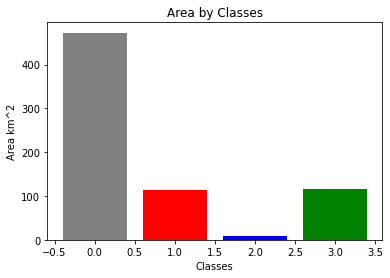

In [40]:
fig, ax = plt.subplots()
ax.bar(classes, sums, color=['gray', 'red', 'blue', 'green'])
ax.set_xlabel("Classes")
ax.set_ylabel("Area km^2")
ax.set_title("Area by Classes")
plt.show()

### Spectral Signature Plots

For supervised classification, it is useful to visualize average spectral responses for each band for each class. Such charts are called Spectral Response Curves or Spectral Signatures. Such charts helps determine separability of classes. If classes have very different signatures, a classifier will be able to separate them well.

We can also plot spectral signatures of all training samples for a class and check the quality of the training dataset. If all training samples show similar signatures - it indicates that you have done a good job of collecting appropriate samples. You can also catch potential outliers from these plots.

These charts provide a qualitative and visual methods for checking separability of classes. For quantitative methods, one can apply measures such as Spectral Distance, Mahalanobis distance, Bhattacharyya distance , Jeffreys-Matusita (JM) distance etc. You can find the code for these in this [Stack Exchange answer](https://gis.stackexchange.com/questions/313678/a-reproducible-example-for-the-use-of-separability-measures-in-improving-selecti/323778#323778).

In [44]:
gcps = ee.FeatureCollection("users/ujavalgandhi/e2e/bangalore_gcps")
composite = ee.Image('users/ujavalgandhi/e2e/bangalore_composite')

# Overlay the point on the image to get bands data.
training = composite.sampleRegions(**{
  "collection": gcps, 
  "properties": ['landcover'], 
  "scale": 10
})


# We will create a chart of spectral signature for all classes

# We have multiple GCPs for each class
# Use a grouped reducer to calculate the average reflectance
# for each band for each class

# We have 12 bands so need to repeat the reducer 12 times
# We also need to group the results by class
# So we find the index of the landcover property and use it
# to group the results
bands = composite.bandNames()
numBands = bands.length()
bandsWithClass = bands.add('landcover')
classIndex = bandsWithClass.indexOf('landcover')

# Use .combine() to get a reducer capable of 
# computing multiple stats on the input
combinedReducer = ee.Reducer.mean().combine(**{
  "reducer2": ee.Reducer.stdDev(),
  "sharedInputs": True})

# Use .repeat() to get a reducer for each band
# We then use .group() to get stats by class
repeatedReducer = combinedReducer.repeat(numBands).group(classIndex)

gcpStats = training.reduceColumns(**{
    "selectors": bands.add('landcover'),
    "reducer": repeatedReducer,
})

# Result is a dictionary, we do some post-processing to
# extract the results
groups = ee.List(gcpStats.get('groups'))

classNames = ee.List(['urban', 'bare', 'water', 'vegetation'])

def extract_means(feature):
    values = ee.Dictionary(feature).get("mean")
    group_num = ee.Dictionary(feature).get("group")
    props = ee.Dictionary.fromLists(bands, values)
    with_class = props.set("class", classNames.get(group_num))
    return ee.Feature(None, with_class)

fc = ee.FeatureCollection(groups.map(extract_means))

In [48]:
info = fc.getInfo()

In [65]:
classes = list()
ys = list()

for class_info in info["features"]:
    props = list(class_info["properties"].values())
    classes.append(props[-1])
    ys.append(props[:-1])

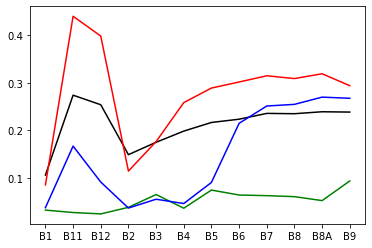

In [78]:
colors = ["black", "red", "green", "blue"]
fig, ax = plt.subplots()
x = ['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']
for i in range(len(ys)):
    ax.plot(x, ys[i], color=colors[i])
plt.show()

## User Interface Templates

### Adding a Discrete Legend

You may want to add a legend for a classified image to your map visualization in your App. Here’s a code snippet that shows how you can build it using the UI Widgets.

In [83]:
classified = ee.Image("users/ujavalgandhi/e2e/bangalore_classified")
Map.centerObject(classified)
Map.addLayer(classified,
  {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']}, '2019')

legend_dict = {
    'Built-up': (128,128,128),
    'Bare Earth': (165,42,42),
    'Water': (0,0,255),
    "Vegetation": (0,128,0)
}
Map.add_legend(legend_title='Legend', legend_dict=legend_dict, position='bottomright')

### Adding a Continous Legend

If you are displaying a raster layer in your app with a color palette, you can use the following technique to add a colorbar using the snipet below.

In [85]:
s2 = ee.ImageCollection("COPERNICUS/S2")
admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

bangalore = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Bangalore Urban'))
geometry = bangalore.geometry()

filtered = s2.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2019-12-31'))\
    .filter(ee.Filter.geometry(geometry))

image = filtered.median()

# Calculate  Normalized Difference Vegetation Index (NDVI)
# 'NIR' (B8) and 'RED' (B4)
ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi']);

palette = ['#d7191c','#fdae61','#ffffbf','#a6d96a','#1a9641']
ndviVis = {"min": 0, "max": 0.5, "palette": palette}
Map.centerObject(geometry, 12)
Map.addLayer(ndvi.clip(geometry), ndviVis, 'ndvi')

colors = palette.copy()
vmin = ndviVis['min']
vmax = ndviVis['max']

Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="ndvi")

### Split Panel App Template

A common use-case for Earth Engine Apps is to display 2 images in a split panel app. The below script contains a simple template that you can use to create an interactive split panel app. Here we have 2 map objects - leftMap and rightMap.

In [87]:
preStorm = ee.Image('COPERNICUS/S2/20180604T052651_20180604T053435_T43RGM')
postStorm = ee.Image('COPERNICUS/S2/20180614T052651_20180614T053611_T43RGM')

rgb_vis = { "min": 0, "max": 3200, "bands": ['B4', 'B3', 'B2'] }

left_layer = geemap.ee_tile_layer(preStorm, rgb_vis, 'pre-storm')
right_layer = geemap.ee_tile_layer(postStorm, rgb_vis, 'post-storm')

Map = geemap.Map()
Map.centerObject(preStorm, 11)
Map.split_map(left_layer, right_layer)
Map

Map(center=[28.407942256394055, 77.60123181002064], controls=(WidgetControl(options=['position', 'transparent_…

---